In [1]:
import numpy as np

In [7]:
-np.sum(np.log([1/6,1/7]))

3.7376696182833684

In [12]:
l1 = [1/2]*6
l2 = [1/6]*6
print(l1,l2)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5] [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]


In [13]:
s1 = -np.sum(l1*np.log(l1))
s2 = -np.sum(l2*np.log(l2))
print(s1,s2)

2.07944154168 1.79175946923


In [10]:
def entropy(num):
    print(num ,"编码长度：",np.log2(1/num),", 信息熵",num * np.log2(1/num)) 

In [11]:
entropy(0.06)
entropy(0.19)
entropy(0.56)
entropy(0.19)

0.06 编码长度： 4.05889368905 , 信息熵 0.243533621343
0.19 编码长度： 2.39592867633 , 信息熵 0.455226448503
0.56 编码长度： 0.836501267717 , 信息熵 0.468440709922
0.19 编码长度： 2.39592867633 , 信息熵 0.455226448503


In [8]:
0.06 * np.log2(0.06)

-0.2435336213432141

In [12]:
entropy(0.21)

0.21 编码长度： 2.251538767 , 信息熵 0.472823141069


In [1]:
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 图片搜集

In [8]:
img = cv2.imread("/Users/weduoo/Desktop/wlwz/pre/103408700_1.jpg")

In [9]:
img.shape[:2]

(900, 1600)

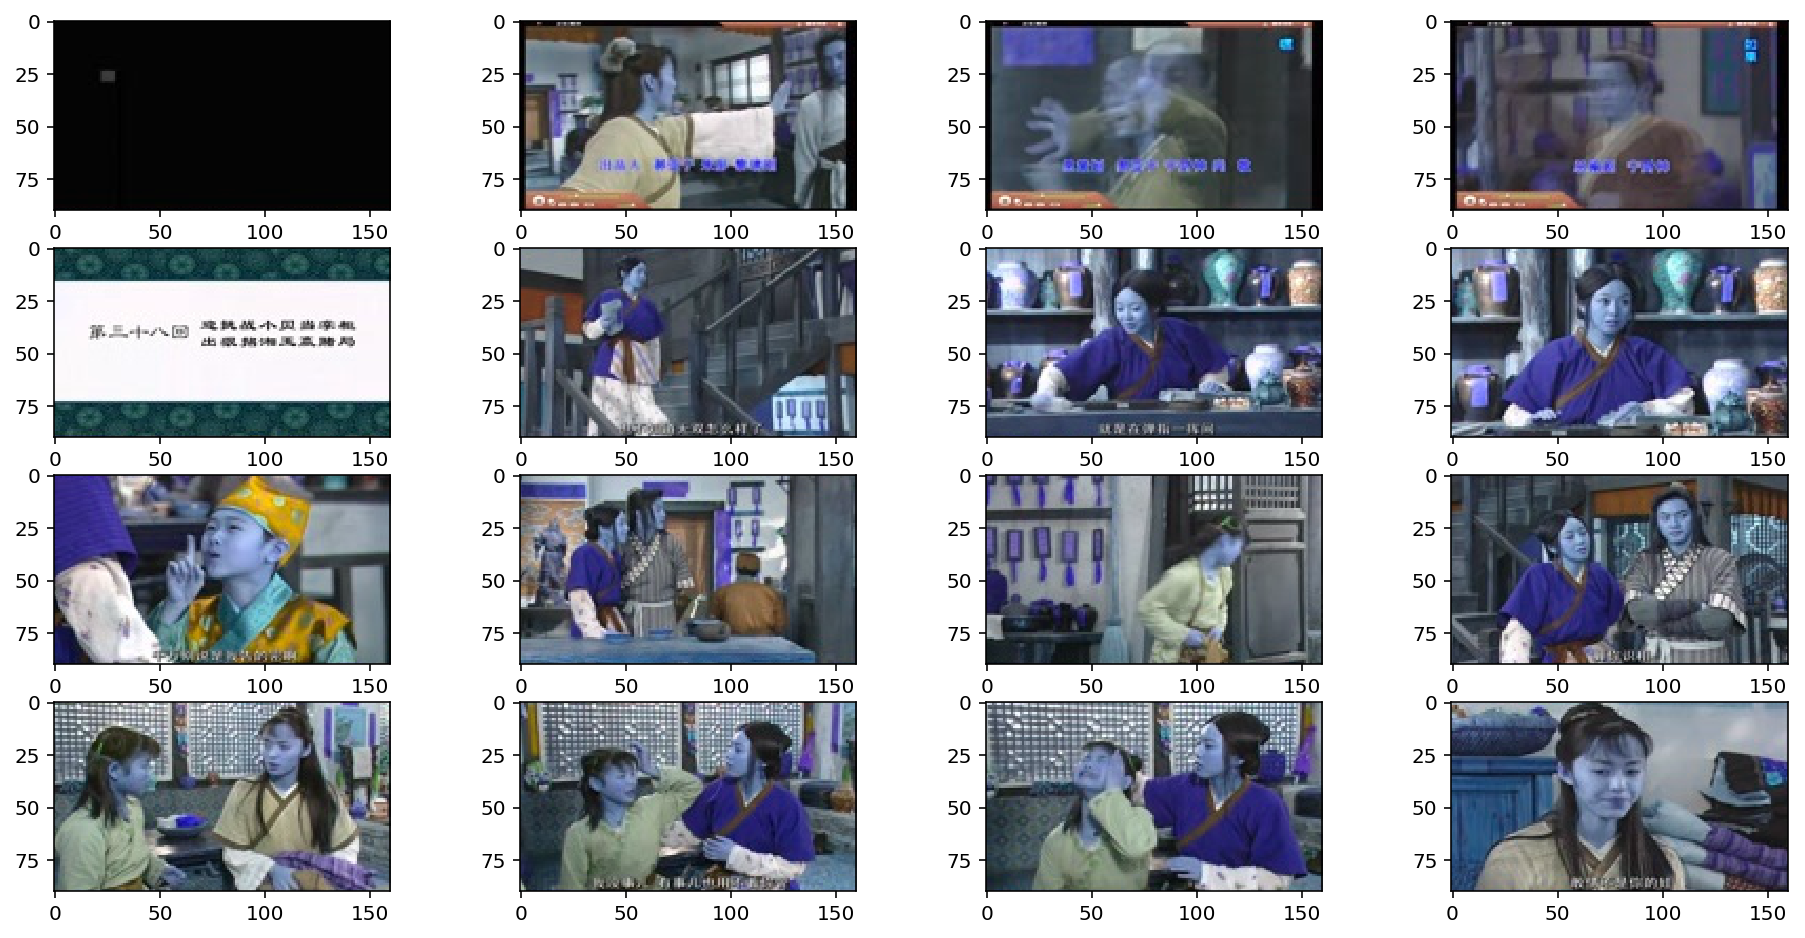

In [13]:

plt.figure(figsize=(16, 8))
k = 0
for i in range(4):
    for j in range(4):
        k += 1
        plt.subplot(4,4,k)
        subimg = img[(0+i*90):(90+i*90),(0+j*160):(160+j*160)]
        plt.imshow(subimg)
plt.show()

## 实时视频流检测

In [2]:
import imutils
import sys
from imutils.video import VideoStream
from imutils.video import FPS

In [4]:
vpath = "/Users/weduoo/迅雷下载/武林外传全集/[武林外传].01.郭女侠怒砸同福店.佟掌柜妙点迷路人.rmvb"

In [15]:
vs = VideoStream(src=vpath).start()
fps = FPS().start()

In [ ]:
while True:
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

In [5]:
def CatchUsbVideo(window_name, camera_idx):
    cv2.namedWindow(window_name)
    
    #视频来源，可以来自一段已存好的视频，也可以直接来自USB摄像头
    cap = cv2.VideoCapture(vpath)        
        
    while cap.isOpened():
        ok, frame = cap.read() #读取一帧数据
        if not ok:            
            break                    
                        
        #显示图像并等待10毫秒按键输入，输入‘q’退出程序
        cv2.imshow(window_name, frame)
        c = cv2.waitKey(10)
        if c & 0xFF == ord('q'):
            break        
    
    #释放摄像头并销毁所有窗口
    cap.release()
    cv2.destroyAllWindows()

CatchUsbVideo("截取视频流", int(0))

## 整理数据

In [6]:
import shutil
import os
import tqdm
data_path = "/Users/weduoo/Desktop/stream/data"

In [11]:
names = {"txy":"佟湘玉","bzht":"白展堂","gfr":"郭芙蓉","lxc":"吕秀才","ldz":"李大嘴"}
def gen_data():
    for key in names:
        count = 1
        src = data_path + "/train/" + names[key]
        dst = data_path + "/test/test/"
        files = os.listdir(src)
        for i in range(1,201):
            rename = src + "/" + key + "_" +str(i) + ".jpg"
            os.rename(src + "/" + files[i*20],rename)
            shutil.move(rename, dst)
gen_data()

验证数据

In [22]:
from sklearn.model_selection import train_test_split
def split_data():
    for key in names:
        src = data_path + "/train/" + names[key]
        files = [ f for f in os.listdir(src) if not f.startswith('.')]
        # 切分训练数据
        img_train, img_cv = train_test_split(files, test_size=0.2, random_state=32)
        print(names[key],len(img_train), len(img_cv))
        dst = data_path + "/valid/" + names[key]
        for file in img_cv:
            shutil.move(src + "/" + file, dst)
split_data()

佟湘玉 8508 2127
白展堂 7106 1777
郭芙蓉 3079 770
吕秀才 3586 897
李大嘴 3964 992


# CNN 模型搭建

## 数据集准备

In [4]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint
import h5py

Using TensorFlow backend.


In [7]:
# 设定图片的大小
width,height=64,64
image_size = (width,height)
# 生成训练与验证图片
gen = ImageDataGenerator(rescale=1. / 255)
train_generator = gen.flow_from_directory(
        data_path + '/train',
        target_size=image_size,
        shuffle=False,
        batch_size=16,
        classes=["白展堂","郭芙蓉","李大嘴","吕秀才","佟湘玉"])
validation_generator = gen.flow_from_directory(
        data_path + '/valid',
        target_size=image_size, 
        shuffle=False,
        batch_size=16)
test_generator = gen.flow_from_directory(data_path + "/test", target_size=image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

Found 26243 images belonging to 5 classes.
Found 6563 images belonging to 5 classes.
Found 1000 images belonging to 1 classes.


## 构建网络模型

In [8]:
### 用于测试
def test_model(input_shape=None,classes=None):
    model = Sequential() 
    img_input=Input(shape=input_shape)
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))    #1 2维卷积层
    model.add(Activation('relu'))                                  #2 激活函数层

    model.add(Conv2D(32, (3, 3)))                             #3 2维卷积层                             
    model.add(Activation('relu'))                                  #4 激活函数层

    model.add(MaxPooling2D(pool_size=(2, 2)))                      #5 池化层

    model.add(Conv2D(64, (3, 3), padding='same'))         #7  2维卷积层
    model.add(Activation('relu'))                                  #8  激活函数层

    model.add(Conv2D(64, (3, 3)))                             #9  2维卷积层
    model.add(Activation('relu'))                                  #10 激活函数层

    model.add(MaxPooling2D(pool_size=(2, 2)))                      #11 池化层
    model.add(Dropout(0.25)) 
    
    model.add(Flatten())                                           #13 Flatten层
    model.add(Dense(512))                                          #14 Dense层,又被称作全连接层
    model.add(Activation('relu'))                                  #15 激活函数层   
    model.add(Dropout(0.5))                                        #16 Dropout层
    model.add(Dense(classes,activation="softmax"))              #17 Dense层

    return model

tmodel = test_model(input_shape=(64,64,3),classes=5)

In [9]:
tmodel.summary()
tmodel.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 31, 31, 64)        0         
__________

In [196]:
ttrain = tmodel.predict_generator(train_generator)
tvalidation = tmodel.predict_generator(validation_generator)
ttest = tmodel.predict_generator(test_generator)

In [199]:
# 没有添加 model.add(Dropout(0.25))
tmodel.fit_generator(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
1641/1641 [==============================] - 757s 461ms/step - loss: 0.7334 - acc: 0.7253 - val_loss: 7.0459 - val_acc: 0.1467
Epoch 2/10
1641/1641 [==============================] - 768s 468ms/step - loss: 0.1789 - acc: 0.9454 - val_loss: 8.3874 - val_acc: 0.1582
Epoch 3/10
1641/1641 [==============================] - 1077s 656ms/step - loss: 0.0995 - acc: 0.9704 - val_loss: 10.5739 - val_acc: 0.1525
Epoch 4/10
1641/1641 [==============================] - 872s 531ms/step - loss: 0.0656 - acc: 0.9812 - val_loss: 11.4381 - val_acc: 0.1566
Epoch 5/10
1641/1641 [==============================] - 754s 460ms/step - loss: 0.0455 - acc: 0.9877 - val_loss: 12.6199 - val_acc: 0.1533
Epoch 6/10
1641/1641 [==============================] - 835s 509ms/step - loss: 0.0354 - acc: 0.9906 - val_loss: 12.5572 - val_acc: 0.1521
Epoch 7/10
1641/1641 [==============================] - 793s 483ms/step - loss: 0.0248 - acc: 0.9937 - val_loss: 12.9810 - val_acc: 0.1539
Epoch 8/10
1641/1641 [======

In [10]:
# 添加了 model.add(Dropout(0.25))
tmodel.fit_generator(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
1641/1641 [==============================] - 783s 477ms/step - loss: 0.7203 - acc: 0.7364 - val_loss: 8.2780 - val_acc: 0.1559
Epoch 2/10
1641/1641 [==============================] - 756s 461ms/step - loss: 0.1725 - acc: 0.9472 - val_loss: 6.9232 - val_acc: 0.1635
Epoch 3/10
1641/1641 [==============================] - 884s 538ms/step - loss: 0.1040 - acc: 0.9686 - val_loss: 9.4259 - val_acc: 0.1545
Epoch 4/10
1641/1641 [==============================] - 982s 599ms/step - loss: 0.0756 - acc: 0.9782 - val_loss: 10.2452 - val_acc: 0.1548
Epoch 5/10
1641/1641 [==============================] - 980s 597ms/step - loss: 0.0543 - acc: 0.9845 - val_loss: 11.0188 - val_acc: 0.1518
Epoch 6/10
1641/1641 [==============================] - 848s 517ms/step - loss: 0.0440 - acc: 0.9885 - val_loss: 12.5328 - val_acc: 0.1515
Epoch 7/10
1641/1641 [==============================] - 765s 466ms/step - loss: 0.0401 - acc: 0.9900 - val_loss: 12.8966 - val_acc: 0.1530
Epoch 8/10
1641/1641 [========

## 保存模型

In [11]:
# 保存模型与权重
tmodel.save_weights("model/faceweights2.h5")
tmodel.save("model/facemodel2.h5")

## 预测数据

In [215]:
print((ttrain))

[[ 0.20216648  0.20384751  0.1996281   0.19614257  0.19821537]
 [ 0.20168972  0.20443855  0.19884497  0.19605473  0.19897196]
 [ 0.20150226  0.20308229  0.19853035  0.19841143  0.19847368]
 ..., 
 [ 0.20446587  0.20243032  0.19288892  0.1976009   0.20261402]
 [ 0.20356464  0.20398989  0.19454521  0.19460091  0.20329934]
 [ 0.20341888  0.20594315  0.19602647  0.19243328  0.20217824]]


In [232]:
import random
from keras.models import load_model
from keras.preprocessing.image import load_img,img_to_array
p_model = load_model("model/facemodel1.h5")
classes=["白展堂","郭芙蓉","李大嘴","吕秀才","佟湘玉"]
def predict_person(nums=1):
    img_path = "/Users/weduoo/Desktop/stream/data/test/test/"
    images = [ f for f in os.listdir(img_path) if not f.startswith('.')]
    # 加载保存的模型
    
    for i in range(nums):
        file = images[random.randint(0,len(images))]
        img = load_img(img_path + file, False, target_size=(64, 64))
        print(img)
        img = img_to_array(img) / 255.0
        print(type(img))
        img = np.expand_dims(img, axis=0)
        y_pred = p_model.predict(img)
        ind=np.argmax(y_pred,1)
        print(file,classes[ind[0]])
predict_person(1)

<PIL.Image.Image image mode=RGB size=64x64 at 0x1A5342B550>
<class 'numpy.ndarray'>
txy_64.jpg 佟湘玉


In [116]:
def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Preprocessed array.
    """
    return imagenet_utils.preprocess_input(x, mode='tf')

from keras.engine import get_source_inputs
from keras import backend as K
#CNN网络模型类            
def MyModel(input_tensor = None,classes = None,input_shape=None):
    if not K.is_keras_tensor(input_tensor):
        img_input = Input(tensor=input_tensor, shape=input_shape)
    else:
        img_input = input_tensor
    
    #以下代码将顺序添加CNN网络需要的各层，一个add就是一个网络层
    model = Conv2D(32, (3, 3),padding='same')(img_input) #1 2维卷积层
    model = Activation('relu')(model)                                 #2 激活函数层
 
    model = Conv2D(32, (3, 3))(model)                            #3 2维卷积层                             
    model = Activation('relu')(model)                                  #4 激活函数层

    model = MaxPooling2D(pool_size=(2, 2))(model)                   #5 池化层
    model = Dropout(0.25)(model)                            #6 Dropout层

    model = Conv2D(64, (3, 3), padding='same')(model)       #7  2维卷积层
    model = Activation('relu')(model)                               #8  激活函数层

    model = Conv2D(64, (3, 3))(model)                          #9  2维卷积层
    model = Activation('relu')(model)                                #10 激活函数层

    model = MaxPooling2D(pool_size=(2, 2))(model)                    #11 池化层
    model = Dropout(0.25)(model)                                       #12 Dropout层

#     model = Flatten()(model)                                    #13 Flatten层
#     model = Dense(512)(model)                                   #14 Dense层,又被称作全连接层
#     model = Activation('relu')(model)                              #15 激活函数层   
#     model = Dropout(0.5)(model)                                      #16 Dropout层
#     model = Dense(5)(model)                               #17 Dense层
#     model = Activation(activation="relu")(model)
    model = GlobalAveragePooling2D()(model)
    
    inputs = get_source_inputs(img_input)
    m = Model(inputs, model, name='mymodel')
    return m

## 特征提取
### 自己搭建

In [117]:
input_t = Input((height, width, 3))
x = input_t
x = Lambda(preprocess_input)(x)

base_model = MyModel(input_tensor=x)
base_model.summary()
model = Model(base_model.input, base_model.output)

train = model.predict_generator(train_generator)
validation = model.predict_generator(validation_generator)
test = model.predict_generator(test_generator)
with h5py.File("wlwz.h5") as h:
    h.create_dataset("train", data=train)
    h.create_dataset("label", data=train_generator.classes)
    h.create_dataset("validation", data=validation)
    h.create_dataset("v_label", data=validation_generator.classes)
    h.create_dataset("test", data=test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
lambda_17 (Lambda)           (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
activation_142 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_143 (Activation)  (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 31, 31, 32)        0         
__________

# 参考
- [Keras上实现卷积神经网络CNN](https://blog.csdn.net/marsjhao/article/details/68490105)
- [keras 多分类一些函数参数设置](https://blog.csdn.net/jasondingwen/article/details/78017927)
- [人脸检测及识别python实现系列（5）——利用keras库训练人脸识别模型](http://www.cnblogs.com/neo-T/p/6477378.html)
- [OpenCV-Python在图片上输出中文](https://blog.csdn.net/dcrmg/article/details/79108491)
- [opencv3.2将中文输出到图片上](http://www.cnblogs.com/arkenstone/p/6961453.html)